In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

<h2>Plots of the coefficients of the predictors for each participant <h2>

In [2]:
#helper function to calculate number of subplots
def calc_subplots(n_datasets,ncolumns):
    subplots = n_datasets
    columns = ncolumns

    rows = subplots // columns

    if subplots % columns != 0:
        rows +=1 

    return (rows, columns)

C:\Users\Rishi\AppData\Local\Temp\ipykernel_6576\2272247282.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ytick_labels)
C:\Users\Rishi\AppData\Local\Temp\ipykernel_6576\2272247282.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ytick_labels)


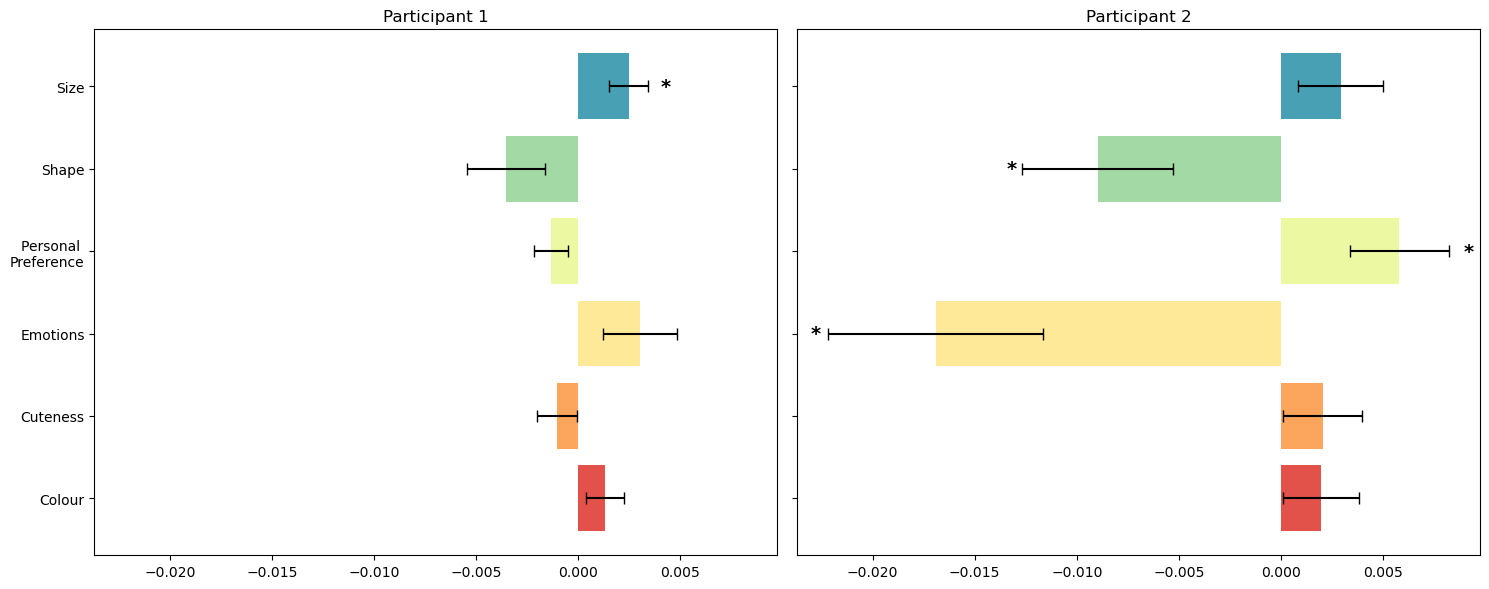

In [73]:
results_folder = os.listdir('LogisticModel_Results')
ppID = 0 #counter for the participants (important later for labelling subplots)

rows, cols = calc_subplots(len(results_folder), 2)
figsize = (15,6)
fig, axes = plt.subplots(rows,cols, figsize = (15,6), sharex=True, sharey=True)
color_palette = sns.color_palette(palette='Spectral') #grab a colour palette for the bars

for index, participant_data in enumerate(results_folder):
    data = pd.read_csv(f'LogisticModel_Results/{participant_data}') #get the dataframe
    data = data.sort_values(by='Predictors', ascending=False)

    ax = axes.flatten()[index] #do this so it effortlessly loops over the subplot axes and plots the participant data

    predictors = data['Predictors']#get the x axis values which will be the coefficients
    coefficients = data['Coef.']
    error = data['Std.Err.'] * 0.95 #for 95% CI
    ytick_labels = ['Colour', 'Cuteness', 'Emotions','Personal \nPreference','Shape','Size'] #reset original labels from the table

    

    #adding asterisks for significant predictors
    sig_predictors = data.loc[data['pvalues'] <= 0.05, 'Predictors'].astype(str)

    for i, row in data.iterrows(): #for each row in the data
        predictor = row['Predictors'] #get the predictor value for that row
        coeff = row['Coef.'] #get the corresponding coefficient value
        stderr = row['Std.Err.']

        if predictor in sig_predictors.values: #and if the predictor is in the list of significant predictors
            xpos = coeff + (stderr + 0.0006)*np.sign(coeff) #x position of the asterisk, offsetting it by 
            #note the 0.0006 was a random number i got by playing around to ensure the asterisk lands a little over
            #the upper bound of the error bar
            ypos = predictor
            ax.text(xpos, ypos, '*', ha='left', va='center', fontsize=14, fontweight='bold')

    ax.barh(predictors,coefficients,xerr=error, align='center', capsize=4, color=color_palette)
    ax.set_title(f'Participant {index + 1}')
    ax.set_yticklabels(ytick_labels)

plt.tight_layout()
    
    









In [51]:
data.loc[data['pvalues'] <=0.05, 'Predictors' ]

3    Personal_Preference_d
2               Emotions_d
1               Cuteness_d
Name: Predictors, dtype: object